**Mahan Madani - 99222092**

Assignment 4 (Part 1) - Click-Through Rate Prediction Dataset

## Table of Contents:

- [Load Dataset and Import Libraries](##Load-Dataset-and-Import-Libraries)
- [Basic Data Analysis](##Basic-Data-Analysis)
- [Data Preprocessing](##Data-Preprocessing)
    - [Duplicate Values](###Check-for-Duplicate-Values)
    - [Null Values](###Handle-Null-Values)
    - [Outlier Detection](###Outlier-Detection)
- [Visualization](##Visualization)
    - [Correlation Heatmap](###Correlation-Heatmap)
- [Feature Engineering](##Feature-Engineering)
- [Feature Encoding](##Feature-Encoding)
- [Feature Scaling](##Feature-Scaling)
- [Utility Functions](##Utility-Functions)
- [Train and Evaluate Models](##Train-and-Evaluate-Models)
    - [Random Forest Classifier](###Random-Forest-Classifier)
    - [Logistic Regression](###Logistic-Regression)
    - [Naive Bayes](###Naive-Bayes)
    - [Support Vector Classifier](###Support-Vector-Classifier)
- [Final Results](##Final-Results)

## Load Dataset and Import Libraries

In [78]:
import os, zipfile
import re

import pandas as pd
import numpy as np

from scipy.sparse import hstack

from scipy.stats import zscore
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler  

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV

import warnings
from sklearn.exceptions import ConvergenceWarning

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

In [79]:
# !pip install kaggle

# kaggle token
os.environ['KAGGLE_CONFIG_DIR'] = "./.kaggle"

!kaggle datasets download -p ./dataset swekerr/click-through-rate-prediction


click-through-rate-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [80]:
with zipfile.ZipFile('./dataset/click-through-rate-prediction.zip', 'r') as zip_ref:
    zip_ref.extractall('./dataset')

In [81]:
df = pd.read_csv("dataset/ad_10000records.csv")
print(df.columns)
print(df.shape)

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Gender', 'Country',
       'Timestamp', 'Clicked on Ad'],
      dtype='object')
(10000, 10)


## Basic Data Analysis

In [82]:
pd.options.display.max_columns = None
df.head(3)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0


In [83]:
df.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Clicked on Ad
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,61.660757,35.940100,53840.047721,177.759831,0.491700
std,15.704142,8.572973,13343.708718,40.820951,0.499956
min,32.600000,19.000000,13996.500000,105.220000,0.000000
25%,48.860000,29.000000,44052.302500,140.150000,0.000000
50%,59.590000,35.000000,56180.930000,178.920000,0.000000
75%,76.580000,42.000000,61840.260000,212.670000,1.000000
max,90.970000,60.000000,79332.330000,269.960000,1.000000


In [84]:
df.describe(include=['object', 'bool'])

,Ad Topic Line,City,Gender,Country,Timestamp
count,10000,10000,10000,10000,10000
unique,559,521,2,207,567
top,Cloned explicit middleware,Hubbardmouth,Female,Australia,2016-03-11 00:05:48
freq,344,336,5376,388,255


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  10000 non-null  float64
 1   Age                       10000 non-null  float64
 2   Area Income               10000 non-null  float64
 3   Daily Internet Usage      10000 non-null  float64
 4   Ad Topic Line             10000 non-null  object 
 5   City                      10000 non-null  object 
 6   Gender                    10000 non-null  object 
 7   Country                   10000 non-null  object 
 8   Timestamp                 10000 non-null  object 
 9   Clicked on Ad             10000 non-null  int64  
dtypes: float64(4), int64(1), object(5)
memory usage: 781.4+ KB


## Data Preprocessing

### Check for Duplicate Values

In [86]:
columns_to_check_duplicates = list(df.columns)
print(columns_to_check_duplicates)

duplicated = df.duplicated(subset=columns_to_check_duplicates, keep=False)
duplicate_rows = df[duplicated]

if not duplicate_rows.empty:
    print("Duplicate records found:")
    print(duplicated.sum())
else:
    print("No duplicate records found.")

['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage', 'Ad Topic Line', 'City', 'Gender', 'Country', 'Timestamp', 'Clicked on Ad']
Duplicate records found:
341


If two records store the exact same information across all featrures they're are considered duplicates. 

In this case, 341 duplicate records were found that all must be dropped except the first instance of each record.

In [87]:
df = df.drop_duplicates(keep='first').reset_index(drop=True)
print("DataFrame without dupliactes:")
df.shape

DataFrame without dupliactes:


(9785, 10)

### Handle Null Values

In [88]:
null_counts = df.isnull().sum()
null_table = pd.DataFrame(null_counts, columns=["Null Count"])
null_table

,Null Count
Daily Time Spent on Site,0
Age,0
Area Income,0
Daily Internet Usage,0
Ad Topic Line,0
City,0
Gender,0
Country,0
Timestamp,0
Clicked on Ad,0


No null values found so no further action is required.

### Outlier Detection

In [89]:
z_scores = pd.DataFrame(zscore(df.select_dtypes(include=np.number)))

threshold = 2.5
outliers = df[(z_scores.abs() > threshold).any(axis=1)]

print("Outlier records:")
print(outliers.shape)

Outlier records:
(122, 10)


Using the Z-scores method on all of the numerical features, a total of 122 outlier records were found which must be dropped to reduce processing errors.

In [90]:
df = df[(z_scores.abs() < threshold).all(axis=1)].reset_index(drop=True)

print("DataFrame without outliers:")
print(df.shape)

DataFrame without outliers:
(9663, 10)


## Visualization

In [91]:
df.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Ad Topic Line', 'City', 'Gender', 'Country',
       'Timestamp', 'Clicked on Ad'],
      dtype='object')

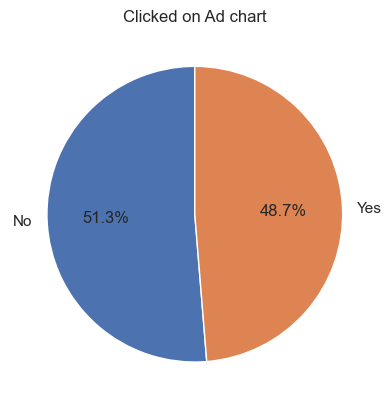

In [92]:
df['Clicked on Ad'].value_counts().plot(kind='pie', labels=['No', 'Yes'], autopct='%1.1f%%', startangle=90)

plt.title('Clicked on Ad chart')
plt.ylabel('')
plt.show()

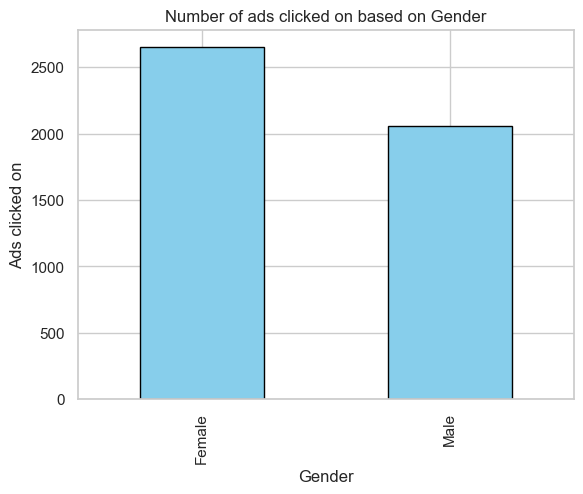

In [93]:
df[df['Clicked on Ad'] == 1].groupby('Gender')['Clicked on Ad'].sum().plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Number of ads clicked on based on Gender')
plt.ylabel('Ads clicked on')
plt.xlabel('Gender')
plt.show()

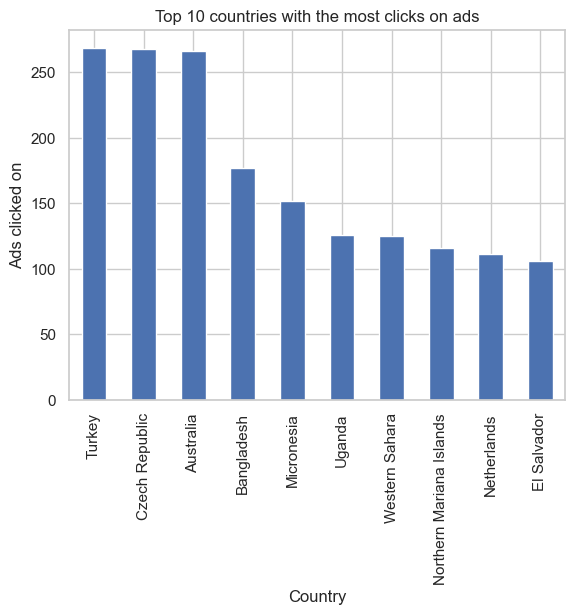

In [94]:
df[df['Clicked on Ad'] == 1]['Country'].value_counts().head(10).plot(kind='bar')

plt.title('Top 10 countries with the most clicks on ads')
plt.ylabel('Ads clicked on')
plt.xlabel('Country')
plt.show()

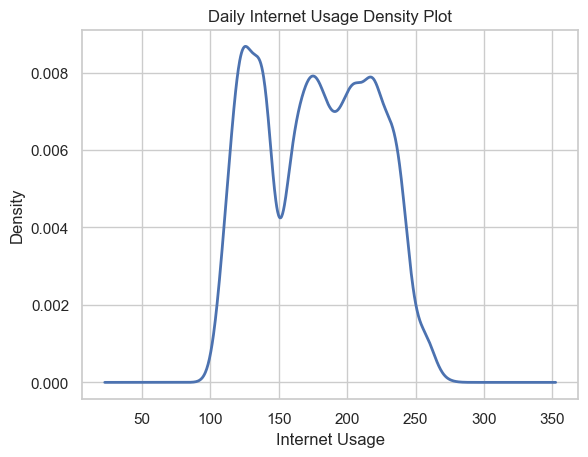

In [95]:
df['Daily Internet Usage'].plot(kind='density', linewidth=2.0)

plt.title('Daily Internet Usage Density Plot')
plt.ylabel('Density')
plt.xlabel('Internet Usage')
plt.show()

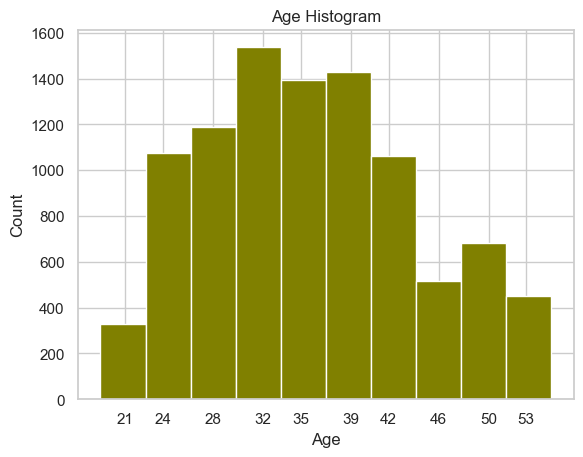

In [96]:
_ , bins, _ = plt.hist(df['Age'], bins=10, edgecolor='white', linewidth=1, color='olive')

# Set the x-ticks to the bin centers (rounded)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
rounded_bin_centers = np.round(bin_centers).astype(int)

plt.xticks(rounded_bin_centers)

plt.title('Age Histogram')
plt.ylabel('Count')
plt.xlabel('Age')
plt.show()

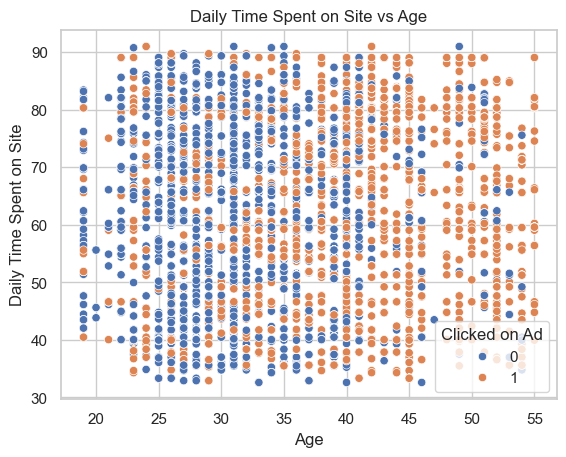

In [97]:
sns.scatterplot(data=df, y='Daily Time Spent on Site', x='Age', hue='Clicked on Ad')

plt.title('Daily Time Spent on Site vs Age')
plt.ylabel('Daily Time Spent on Site')
plt.xlabel('Age')
plt.show()

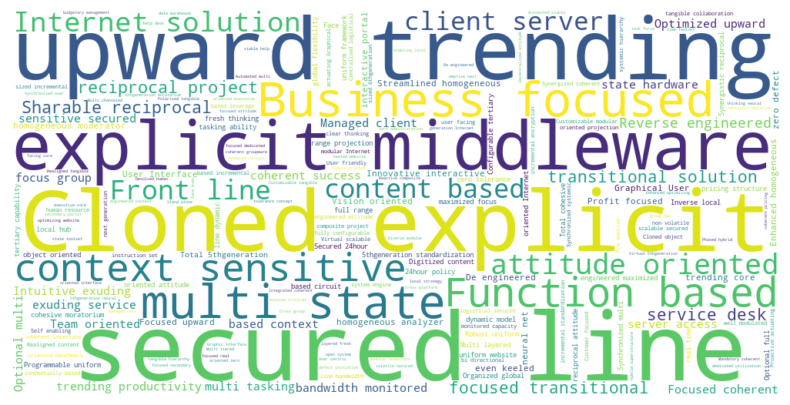

In [98]:
text_corpus = ' '.join(df['Ad Topic Line'])
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text_corpus)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


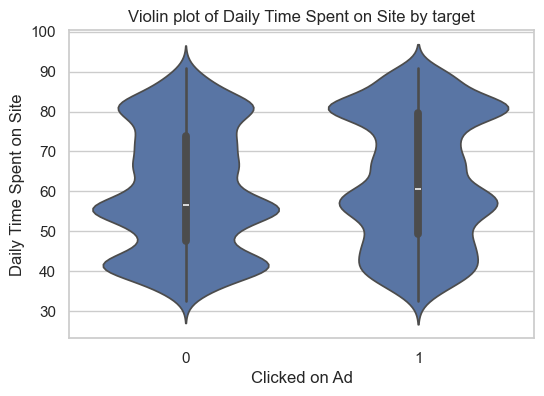

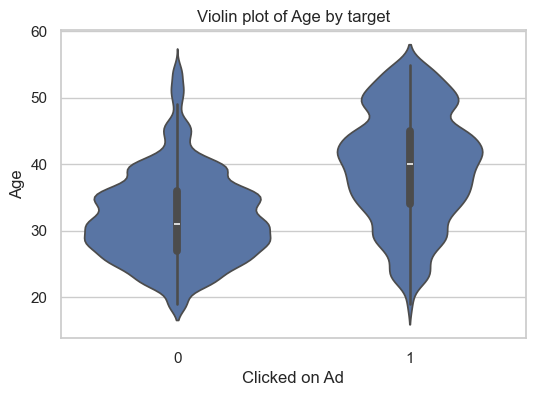

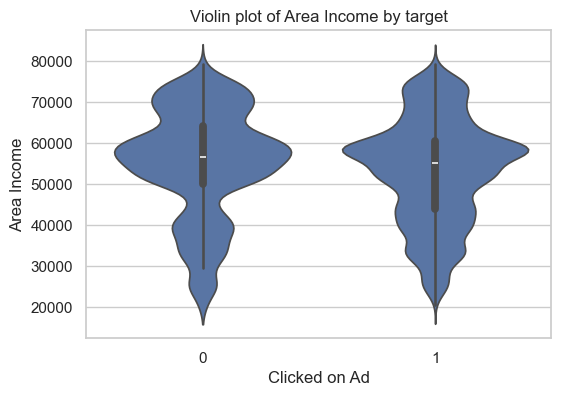

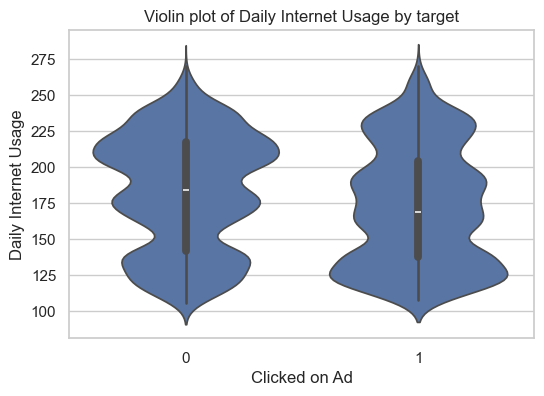

In [99]:
sns.set_theme(style="whitegrid")

# Create a violin plot for each numerical feature
for column in df.select_dtypes('number').drop('Clicked on Ad', axis=1).columns:
    plt.figure(figsize=(6, 4))
    sns.violinplot(x='Clicked on Ad', y=column, data=df)
    plt.title(f'Violin plot of {column} by target')
    plt.show()


### Correlation Heatmap

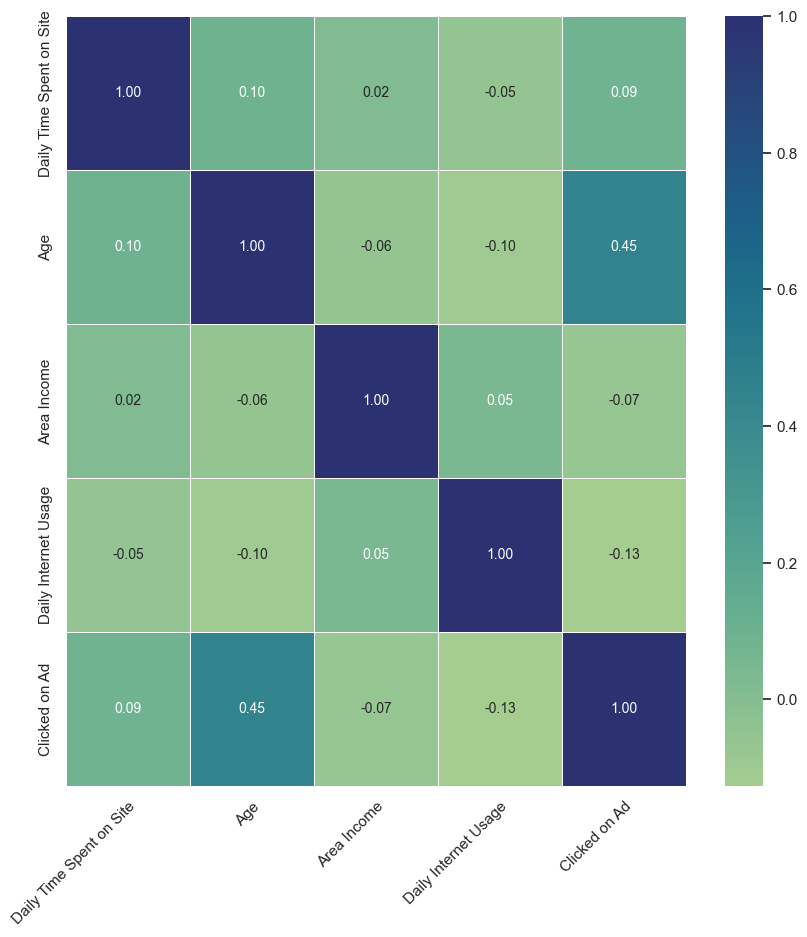

In [100]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='crest', annot_kws={"fontsize": 10}, fmt='.2f', linewidths=0.5, cbar=True)
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

## Feature Engineering

In [101]:
df.sample(3)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
4949,47.64,49.0,45632.51,168.34,Advanced 24/7 productivity,West Brandonton,Female,Netherlands,2016-02-05 16:50:58,1
5117,39.85,24.0,47258.59,182.20,Vision-oriented attitude-oriented Internet sol...,Williamsport,Female,Peru,2016-06-29 02:48:44,1
1573,81.98,23.0,25739.09,236.87,Managed disintermediate capability,Hubbardmouth,Female,Cuba,2016-05-19 14:30:17,1


Each record contains a `Daily Time Spent on Site` feature and a `Daily Internet Usage` feature. Using both features, we can determine what percentage of a user's online activity is done on the specified website.

`Percentage of Daily Time Spent on Site` is created by dividing the time spent on the site by the daily internet usage.

In [102]:
df['Percentage of Daily Time Spent on Site'] = df['Daily Time Spent on Site'] / df['Daily Internet Usage']

Based on the EDA performed, we can infer that `Age` is highly correlated with the target variable. A rough guess based on one of our scatter plots shows that people over the Age of 35 are more likely to click on ads. Therefore, a new feature `Age Over 35` is created.

In [103]:
df['Age Over 35'] = (df['Age'] >= 35).astype(int)

The `Timestamp` feature can be used to extract various time-related data. `Day`, `Day of Week`, `Month`, and `Hour` are extracted. There is no point in adding a Year feature as all records are set in 2016, meaning that year doesn't provide any information that will help discriminate records.

In [104]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Day'] = df['Timestamp'].dt.dayofweek
df['Day Of Week'] = df['Timestamp'].dt.dayofweek

df['Month'] = df['Timestamp'].dt.month
df['Hour'] = df['Timestamp'].dt.hour

An additional feature can be created using the `Hour` feature. Dividing the 24-hour cycle to 4 equal segments, allows us to create a new feature for each `Time Segment`. I created one feature with 4 possible values which can later be one-hot encoded to 4 different features.

In [105]:
# A function to categorize hours into 4 segments
def categorize_time(hour):
    if hour < 6:
        return '0-6'
    elif hour < 12:
        return '6-12'
    elif hour < 18:
        return '12-18'
    else:
        return '18-24'

# Apply the function to create a new feature (must be encoded later)
df['Time Segment'] = df['Hour'].apply(categorize_time)

In [106]:
df.sample(3)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad,Percentage of Daily Time Spent on Site,Age Over 35,Day,Day Of Week,Month,Hour,Time Segment
8342,50.19,36.0,32549.95,203.90,Ameliorated actuating workforce,Youngfort,Male,Belize,2016-02-27 12:34:19,1,0.246150,1,5,5,2,12,12-18
6154,43.49,37.0,74903.41,109.29,Decentralized needs-based analyzer,Jordantown,Male,Libyan Arab Jamahiriya,2016-07-08 03:47:41,0,0.397932,1,4,4,7,3,0-6
8694,89.05,50.0,43778.88,122.31,Ameliorated discrete extranet,North Kimberly,Female,Bangladesh,2016-04-09 09:26:39,1,0.728068,1,5,5,4,9,6-12


## Feature Encoding

The dataset currently has 5 non-numerical features that should be encoded.

In [107]:
df.describe(include='object')

,Ad Topic Line,City,Gender,Country,Time Segment
count,9663,9663,9663,9663,9663
unique,557,520,2,206,4
top,Cloned explicit middleware,Hubbardmouth,Female,Australia,18-24
freq,323,328,5185,329,2871


`Gender` can be encoded as a simple binary feature as the dataset contains 2 possible values for gender.

In [108]:
df['Gender Encoded'], _ = pd.factorize(df['Gender'])

The other 4 features are one-hot encoded to create over 1000 new features. `Time Segment` only has 4 possible values, however `Country` , `City`, and `Ad Topic Line` features are nominal and each have over 200 different possible values. Using other types of encoding is not appropriate here as there is no order or priority defined for these values.

In [109]:
ad_topic_lines = pd.get_dummies(df['Ad Topic Line'], prefix='Ad Topic Line').astype(int)
countries = pd.get_dummies(df['Country'], prefix='Country').astype(int)
cities = pd.get_dummies(df['City'], prefix='City').astype(int)
time_segments = pd.get_dummies(df['Time Segment'], prefix='Time Segment').astype(int)

In [110]:
# Concatenate the one-hot encoded columns with the original DataFrame

X = pd.concat([df, 
                ad_topic_lines,
                countries,
                cities,
                time_segments],
                axis=1)

In [133]:
X.shape

(9663, 1298)

## Feature Scaling

In [111]:
X = X.select_dtypes(include=['number']).drop('Clicked on Ad', axis=1)
y = df['Clicked on Ad']

I used a train-test split to create a sample for training models. Note that the data split happened before data scaling.

In [112]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

Not all numerical features need to be scaled. I only chose appropriate features with high variance and generally higher values (such as `Area Income`) to be scaled. One-hot vectors, for instance, do not need to be scaled.

In [113]:
columns_to_scale = ['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Percentage of Daily Time Spent on Site']

I used a simple preprocessor to apply the scaling to the dataset. Only the specified columns are scaled. There are 2 important things to note here:

- The preprocessor (scaler) is first fit on the `Train` data. Afterward, both the `Train` and `Test` data are transformed using the scaler. This is done to prevent data leakage.
- Later on, the preprocessor is used again for Cross-Validation, where each step requires a separate scaler based on the chosen `Train Folds` and `Test Folds`. 

In [114]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), columns_to_scale)
    ],
    remainder='passthrough'  # Keep the remaining columns as they are
)

# Fit the scaler on the training data
preprocessor.fit(X_train)

# Transform the training and test data using the scaler trained with Train data to prevent data leakage
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

## Utility Functions

I created three utility functions to simplify training and testing various models.


The `perform_cross_validation()`    

In [115]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    print(f"Mean accuracy of train set: {model.score(X_train, y_train):4f}")

In [116]:
def test_model(model, x_test, y_test):
    y_pred = model.predict(x_test)
    y_pred_probability = model.predict_proba(x_test)[:, 1]  # Probability of class 1

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy: >.6}\n")

    # Calculate Precision, Recall, and F1 score
    print(classification_report(y_test, y_pred))

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=[8,3])
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='crest', cbar=False, linewidths=1,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])

    plt.title('Confusion Matrix')


    # Calculate AUC
    auc = roc_auc_score(y_test, y_pred_probability)
    print(f"AUC: {auc: >.6}")

    # Plot the ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probability)

    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [117]:
# This function can accept a model or a pipeline including a model

def perform_cross_validation(model, X, y, repeats=2, folds=5):
    cv = RepeatedStratifiedKFold(n_splits=folds, n_repeats=repeats, random_state=13)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)

    print("Cross-validation scores:", scores)
    print("Best result:", max(scores))
    

## Train and Evaluate Models

I trained and test 4 different models which can be viewed below. Each model is first tested with the sample `Train` and `Test` datasets, and then Cross-Validation is used.

### Random Forest Classifier

Mean accuracy of train set: 0.999741
Accuracy: 0.866011

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       989
           1       0.88      0.84      0.86       944

    accuracy                           0.87      1933
   macro avg       0.87      0.87      0.87      1933
weighted avg       0.87      0.87      0.87      1933

AUC: 0.936866


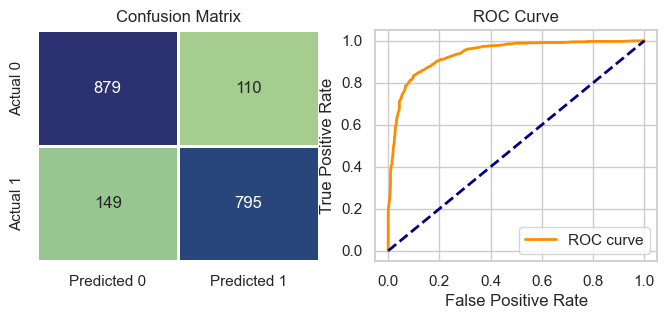

In [118]:
random_forest_model = RandomForestClassifier(random_state=13)
train_model(random_forest_model, X_train, y_train)
test_model(random_forest_model, X_test, y_test)

Random Forest Cross-Validation with the scaler set to the previously defined `preprocessor`.
- Note that utilizing this Pipeline with cross-validation ensures the scaler is fit on the train data and then it gets used to transform both the train and test data. This step is repeated for each selection of folds, meaning the scaler is fit separately on each selection of train folds. No DATA LEAKAGE OCCURS WITH THIS METHOD.

In [119]:
pipeline = Pipeline([
    ('scaler', preprocessor),
    ('model', RandomForestClassifier(random_state=13))
])

perform_cross_validation(pipeline, X, y, folds=5, repeats=1)

Cross-validation scores: [0.86239007 0.87273668 0.86187274 0.86076605 0.88405797]
Best result: 0.8840579710144928


Random Forest Cross-Validation With Custom Scaling and PCA (Applied after scaling the data. PCA expects the data to follow a normal distribution)

In [120]:
pipeline = Pipeline([
    ('scaler', preprocessor),
    ('pca', PCA(n_components=200)),
    ('model', RandomForestClassifier(random_state=13))
])

perform_cross_validation(pipeline, X, y, folds=5, repeats=1)

Cross-validation scores: [0.87894465 0.87273668 0.87377134 0.85766046 0.8742236 ]
Best result: 0.8789446456285567


### Logistic Regression

Mean accuracy of train set: 0.903622
Accuracy: 0.883083

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       989
           1       0.88      0.88      0.88       944

    accuracy                           0.88      1933
   macro avg       0.88      0.88      0.88      1933
weighted avg       0.88      0.88      0.88      1933

AUC: 0.947087


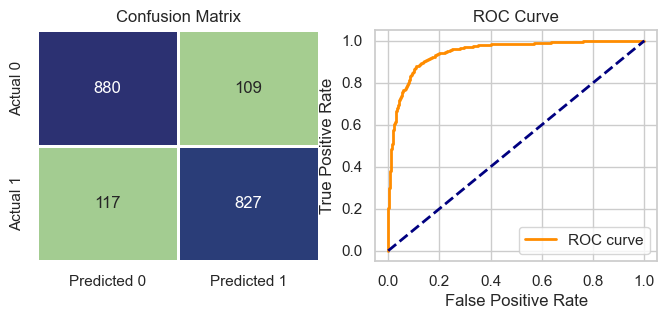

In [121]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

LR_model = LogisticRegression(random_state=13, penalty='elasticnet', solver='saga', l1_ratio=0.4, max_iter=200)
train_model(LR_model, X_train, y_train)
test_model(LR_model, X_test, y_test)

Logistic Regression Cross-Validation WITHOUT Scaling

In [122]:
pipeline = Pipeline([
    ('model', LogisticRegression(random_state=13, penalty='elasticnet', solver='saga', l1_ratio=0.4, max_iter=200))
])

perform_cross_validation(pipeline, X, y, folds=5, repeats=1)

Cross-validation scores: [0.51370926 0.5126746  0.51319193 0.51345756 0.51293996]
Best result: 0.5137092602172788


Logistic Regression Cross-Validation WITH Standard Scaling (all features are scaled)

In [123]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=13, penalty='elasticnet', solver='saga', l1_ratio=0.4, max_iter=200))
])

perform_cross_validation(pipeline, X, y, folds=5, repeats=1)

Cross-validation scores: [0.874806   0.85876875 0.86549405 0.85507246 0.87732919]
Best result: 0.8773291925465838


Logistic Regression Cross-Validation WITH Custom Scaling (using the preprocessor)

** BEST RESULT **

In [124]:
pipeline = Pipeline([
    ('scaler', preprocessor),
    ('model', LogisticRegression(random_state=13, penalty='elasticnet', solver='saga', l1_ratio=0.4, max_iter=200))
])

perform_cross_validation(pipeline, X, y, folds=5, repeats=1)

Cross-validation scores: [0.88722193 0.87842732 0.88566994 0.86180124 0.89389234]
Best result: 0.8938923395445134


Logistic Regression Cross-Validation WITH Custom Scaling and PCA

In [125]:
pipeline = Pipeline([
    ('scaler', preprocessor),
    ('pca', PCA(n_components=200)),
    ('model', LogisticRegression(random_state=13, penalty='elasticnet', solver='saga', l1_ratio=0.4, max_iter=200))
])

perform_cross_validation(pipeline, X, y, folds=5, repeats=1)

Cross-validation scores: [0.87635799 0.86549405 0.86394206 0.86128364 0.87163561]
Best result: 0.8763579927573719


### Naive Bayes

Mean accuracy of train set: 0.874256
Accuracy: 0.832902

              precision    recall  f1-score   support

           0       0.89      0.77      0.83       989
           1       0.79      0.90      0.84       944

    accuracy                           0.83      1933
   macro avg       0.84      0.83      0.83      1933
weighted avg       0.84      0.83      0.83      1933

AUC: 0.847423


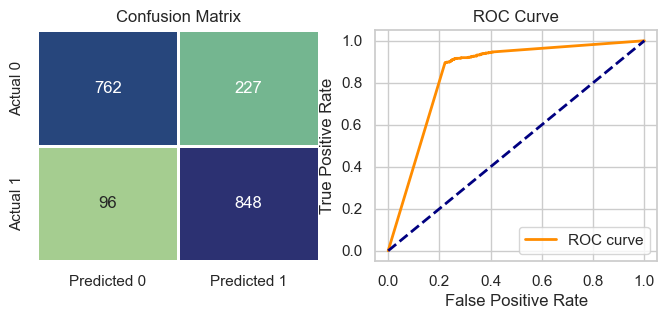

In [126]:
NB_model = GaussianNB()
train_model(NB_model, X_train, y_train)
test_model(NB_model, X_test, y_test)

Naive Bayes Cross-Validation WITH Custom Scaling

In [127]:
pipeline = Pipeline([
    ('scaler', preprocessor),
    ('model', GaussianNB())
])

perform_cross_validation(pipeline, X, y, folds=5, repeats=5)

Cross-validation scores: [0.82721159 0.83704087 0.84997413 0.82039337 0.8447205  0.8375582
 0.82100362 0.83548888 0.84161491 0.83850932 0.84480083 0.81479565
 0.84117951 0.83954451 0.83954451 0.81324366 0.83962752 0.85152613
 0.83488613 0.83333333 0.83135023 0.82928091 0.83135023 0.84627329
 0.82142857]
Best result: 0.851526125193999


Logistic Regression Cross-Validation WITH Custom Scaling and PCA

In [128]:
pipeline = Pipeline([
    ('scaler', preprocessor),
    ('pca', PCA(n_components=200)),
    ('model', GaussianNB())
])

perform_cross_validation(pipeline, X, y, folds=5, repeats=2)

Cross-validation scores: [0.77909984 0.78116917 0.77806518 0.76242236 0.7800207  0.77340921
 0.78479048 0.76151061 0.76086957 0.77743271]
Best result: 0.784790481117434


### Support Vector Classifier

Mean accuracy of train set: 0.790556
Accuracy: 0.780135

              precision    recall  f1-score   support

           0       0.73      0.89      0.81       989
           1       0.85      0.66      0.75       944

    accuracy                           0.78      1933
   macro avg       0.79      0.78      0.78      1933
weighted avg       0.79      0.78      0.78      1933

AUC: 0.87955


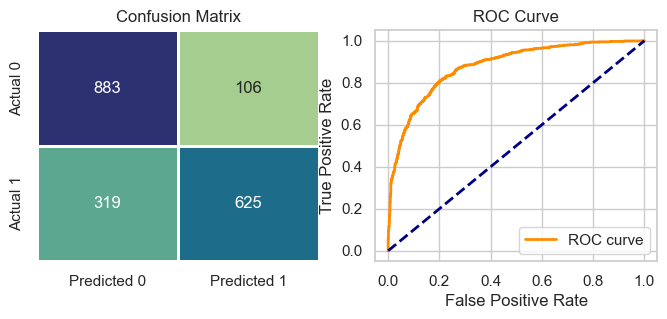

In [129]:
svc = SVC(kernel='poly', C=1.0, probability=True, random_state=13)
train_model(svc, X_train, y_train)
test_model(svc, X_test, y_test)

Mean accuracy of train set: 0.784347
Accuracy: 0.774444

              precision    recall  f1-score   support

           0       0.76      0.81      0.79       989
           1       0.79      0.73      0.76       944

    accuracy                           0.77      1933
   macro avg       0.78      0.77      0.77      1933
weighted avg       0.78      0.77      0.77      1933

AUC: 0.87638


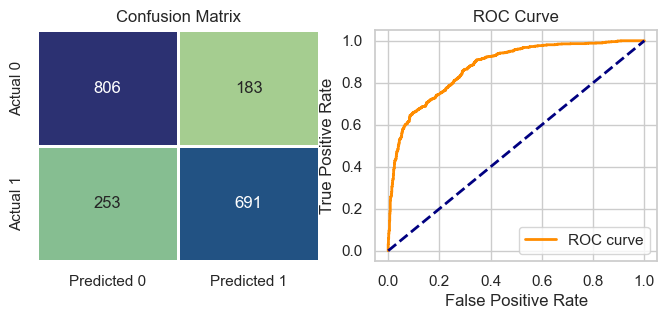

In [130]:
svc = SVC(kernel='rbf', C=1.0, probability=True, random_state=13)
train_model(svc, X_train, y_train)
test_model(svc, X_test, y_test)

Support Vector Classifier (kernel: Polynomial) Cross-Validation WITH Custom Scaling

In [131]:
pipeline = Pipeline([
    ('scaler', preprocessor),
    ('model', SVC(kernel='poly', C=1.0, random_state=13))
])

perform_cross_validation(pipeline, X, y, folds=5, repeats=1)

Cross-validation scores: [0.7682359  0.78323849 0.78116917 0.77691511 0.79554865]
Best result: 0.7955486542443064


Support Vector Classifier (kernel: Polynomial) Cross-Validation WITH Custom Scaling and PCA

In [132]:
pipeline = Pipeline([
    ('scaler', preprocessor),
    ('pca', PCA(n_components=300)),
    ('model', SVC(kernel='poly', C=1.0, random_state=13))
])

perform_cross_validation(pipeline, X, y, folds=5, repeats=1)

Cross-validation scores: [0.8189343  0.82359027 0.81686498 0.80641822 0.83799172]
Best result: 0.837991718426501


## Final Results


Below you can find the best accuracy results I was able to achieve for each model with cross-validation:

* Random Forest Classifier : Scaled + NO PCA
<br>Best CV score: **0.884**

* Logistic Regression : Scaled + NO PCA
<br>Best CV score: **0.893**

* Naive Bayes : Scaled + NO PCA
<br>Best CV score: **0.851**

* Support Vector Classifier : Polynomial kernel + Scaled + PCA applied
<br>Best CV score: **0.837**